In [4]:
!pip install xgboost

# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import all you need</p>

In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import joblib


In [6]:
df= pd.read_csv('/content/tehranhouses.csv' )
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA</p>

In [7]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [8]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [9]:
df.dtypes

,0
Area,object
Room,int64
Parking,bool
Warehouse,bool
Elevator,bool
Address,object
Price,int64
Price(USD),float64


In [10]:
df.isnull().sum()

,0
Area,0
Room,0
Parking,0
Warehouse,0
Elevator,0
Address,23
Price,0
Price(USD),0


In [11]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',', '', x))
df["Area"] = pd.to_numeric(df["Area"] , errors='coerce')

In [12]:
df.dropna(inplace=True)

In [13]:
def chang(x):
    x=x*900000
    return x
df['price(iran)']=df['Price(USD)'].apply(chang)


In [14]:
len(df.Address.unique())

192

# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Visualization</p>

In [15]:
import plotly.figure_factory as ff

corr_matrix = (df.drop(columns="Address")).corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    colorscale="Viridis"
)
fig.update_layout(title="Correlation Heatmap")
fig.show()

# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Preprocessing </p>

In [16]:
df['price(iran)']=df['Price(USD)'].apply(chang)

In [17]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return lower, upper

lower_area, upper_area = lower_upper(df['Area'])
lower_price, upper_price = lower_upper(df['price(iran)'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -9.00
Upper limit for area: 199.00
Lower limit for price: -163,500,007,500.0
Upper limit for price: 386,100,004,500.0


In [18]:
area_outliers = np.where(df['Area'] > upper_area)
price_outliers = np.where(df['price(iran)'] > upper_price)
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

Number of area outliers: 237
Number of price outliers: 310
Number of outliers: 366


In [19]:
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),price(iran)
0,63,1,True,True,True,Shahran,1850000000,61666.67,5.550000e+10
1,60,1,True,True,True,Shahran,1850000000,61666.67,5.550000e+10
2,79,2,True,True,True,Pardis,550000000,18333.33,1.650000e+10
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33,2.707500e+10
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33,2.100000e+11


In [20]:
boolean_features = ['Parking', 'Warehouse', 'Elevator']
df[boolean_features] = df[boolean_features].astype('int64')


In [21]:
X = df.drop(columns=['price(iran)' ,'Price(USD)' , 'Price'], axis=1)
y = df['price(iran)']

In [22]:

address_dummy = pd.get_dummies(X['Address'])
X = X.join(address_dummy)
X.drop(columns='Address', inplace=True)



# Model Building

In [23]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


# <p style="padding:10px;background-color:#A020F0;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">build best model</p>

In [24]:
from xgboost import XGBRegressor


def XGBR(X_train, X_test,y_train, y_test):

    model = XGBRegressor()

    ## params
    n_estimators=[1000]
    max_depth = [3, 4, 5]
    learning_rate=[0.01, 0.02, 0.04, 0.1, 0.2]
    subsample=[0.6, 0.8]
    colsample_bytree=[0.6, 0.8]
    num_leaves = [5, 20, 31]


    grid = dict(max_depth=max_depth, num_leaves=num_leaves, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators)
    cv = TimeSeriesSplit(n_splits=10)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)

    best_params = grid_result.best_params_
    xgb = XGBRegressor(max_depth=best_params['max_depth'], num_leaves=best_params['num_leaves'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], n_estimators=best_params['n_estimators'])
    accuracies = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = cv)

    Accuracy_CrossVal = "{:.2f} %".format(accuracies.mean()*100)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    joblib.dump(xgb,'pre_price.joblib')


    rmse = "%f" % (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = "%f" % (np.abs(r2_score(y_test, y_pred)))
    mae ="%f" % (np.sqrt(mean_absolute_error(y_test, y_pred)))

    plt.figure(figsize=(10, 5), dpi=80)
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="test")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Carbon Dioxide Emissions - Test and Predicted data")
    plt.legend()
    plt.show()


    return Accuracy_CrossVal, rmse, r2, mae


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[16:54:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: {

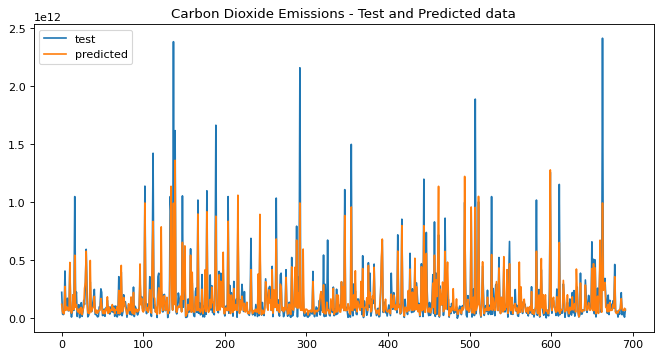

('63.78 %', '139323694408.979645', '0.751126', '247183.373285')

In [25]:
XGBR(X_train, X_test, y_train, y_test)

In [26]:
X_train

,Area,Room,Parking,Warehouse,Elevator,Abazar,Abbasabad,Absard,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
619,84,2,1,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,53,1,0,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
70,90,1,0,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3012,71,2,1,1,0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
29,100,2,1,1,1,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,51,1,1,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3281,80,2,1,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1659,43,1,0,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2620,75,2,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
